In [ ]:
import numpy as np
import pandas as pd
import random
from collections import deque
import operator
import matplotlib.pyplot as plt
import seaborn as sns

Priority Replay Buffer

In [ ]:
class PrioritizedReplayBuffer:
#Priority-based experience replay buffer that stores experiences based on their importance, determined by the temporal difference (TD) error.
    def __init__(self, size=1000, alpha=0.6):
        self.alpha = alpha
        self.buffer = deque(maxlen=size)
        self.priorities = deque(maxlen=size)

    def add(self, experience, error):
#Adds experiences to the buffer with a priority level determined by the TD error.
        priority = (abs(error) + 1e-5) ** self.alpha
        self.buffer.append(experience)
        self.priorities.append(priority)

    def sample(self, batch_size):
#Samples a batch of experiences based on their priority weights.
        probabilities = np.array(self.priorities) / sum(self.priorities)
        selected_indices = np.random.choice(range(len(self.buffer)), size=batch_size, p=probabilities)
        return [self.buffer[i] for i in selected_indices], selected_indices

    def update_priorities(self, indices, errors):
#Updates priorities for sampled experiences after learning from them.
        for index, error in zip(indices, errors):
            self.priorities[index] = (abs(error) + 1e-5) ** self.alpha


Agent Class



In [ ]:
class Agent:
#Defines an RL agent with a Q-table for storing and updating action values, utilizing prioritized experience replay.
    def __init__(self, learning_rate, discount_factor, initial_epsilon, min_epsilon, epsilon_decay, buffer_size=1000):
        self.q_table = {}
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.memory = PrioritizedReplayBuffer(size=buffer_size)

    def init_state(self, state):
#Initializes the Q-values for all actions of a state if it hasn't been visited.
        if state not in self.q_table:
            self.q_table[state] = {'up': 0, 'down': 0, 'left': 0, 'right': 0}

    def choose_action(self, state):
#Chooses an action using epsilon-greedy policy.
        self.init_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.choice(['up', 'down', 'left', 'right'])
        return max(self.q_table[state], key=self.q_table[state].get)

    def update_epsilon(self):
#Decays the epsilon value to reduce exploration over time.
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

    def update_q_value(self, state, action, reward, next_state):
#Updates the Q-value for a given state and action using the Bellman equation.
        self.init_state(next_state)
        old_value = self.q_table[state][action]
        next_max = max(self.q_table[next_state].values())
        new_value = old_value + self.lr * (reward + self.gamma * next_max - old_value)
        self.q_table[state][action] = new_value

    def replay(self, batch_size=32):
#Updates Q-values for a batch of experiences sampled from the prioritized replay buffer.
        experiences, indices = self.memory.sample(batch_size)
        errors = []
        for (state, action, reward, next_state) in experiences:
            self.init_state(state)
            self.init_state(next_state)
            current_q = self.q_table[state][action]
            next_max_q = max(self.q_table[next_state].values())
            error = reward + self.gamma * next_max_q - current_q
            errors.append(error)
            self.update_q_value(state, action, reward, next_state)
        self.memory.update_priorities(indices, errors)


Enviromental Class




In [ ]:
class Environment:
    def __init__(self, size=(5, 5), num_objects=0):
        self.size = size
        self.num_objects = num_objects
        self.grid = np.zeros(self.size)  # Initialize a grid of zeros
        self.place_objects()
        self.reset()

    def place_objects(self):
        count = 0
        while count < self.num_objects:
            x, y = np.random.randint(0, self.size[0]), np.random.randint(0, self.size[1])
            if (x, y) not in [(0, 0), (self.size[0]-1, self.size[1]-1)] and self.grid[x, y] == 0:
                self.grid[x, y] = 2  # Using 2 to denote objects
                count += 1

    def reset(self):
        self.agent_position = [0, 0]
        self.goal_position = [self.size[0] - 1, self.size[1] - 1]
        self.grid[self.agent_position[0], self.agent_position[1]] = 1  # Agent's start position
        self.grid[self.goal_position[0], self.goal_position[1]] = 3  # Goal position
        return tuple(self.agent_position)

    def step(self, action):
        x, y = self.agent_position
        moves = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        dx, dy = moves[action]
        new_x, new_y = x + dx, y + dy

        if 0 <= new_x < self.size[0] and 0 <= new_y < self.size[1]:
            if self.grid[new_x, new_y] != 2:  # Not blocked by an object
                self.grid[x, y] = 0  # Clear old position
                self.agent_position = [new_x, new_y]
                self.grid[new_x, new_y] = 1  # Move agent

        reward = -1
        done = tuple(self.agent_position) == tuple(self.goal_position)
        if done:
            reward = 100
        return tuple(self.agent_position), reward, done


Genetic Algorithm Setup


In [ ]:
def crossover(agent1, agent2):
    child_lr = (agent1.lr + agent2.lr) / 2
    child_gamma = (agent1.gamma + agent2.gamma) / 2
    child_epsilon = (agent1.epsilon + agent2.epsilon) / 2
    child_min_epsilon = min(agent1.min_epsilon, agent2.min_epsilon)
    child_epsilon_decay = (agent1.epsilon_decay + agent2.epsilon_decay) / 2

    return Agent(
        learning_rate=child_lr,
        discount_factor=child_gamma,
        initial_epsilon=child_epsilon,
        min_epsilon=child_min_epsilon,
        epsilon_decay=child_epsilon_decay,
        buffer_size=1000,
        learning_method=agent1.learning_method
    )

def mutate(agent, mutation_rate=0.1):
    if random.random() < mutation_rate:
        agent.lr += random.uniform(-0.05, 0.05)
        agent.gamma += random.uniform(-0.05, 0.05)
        agent.epsilon += random.uniform(-0.05, 0.05)
        agent.min_epsilon = max(0, agent.min_epsilon - 0.01)
        agent.epsilon_decay = max(0.9, agent.epsilon_decay - 0.01)
    return agent

def genetic_algorithm(population, generations):
    for g in range(generations):
        new_population = [mutate(agent) for agent in population]  # Apply mutation to all
        for _ in range(len(population)//2):
            parent1, parent2 = random.sample(population, 2)
            child = crossover(parent1, parent2)
            new_population.append(child)
        population = new_population[:len(population)]  # Maintain population size
    return population

Simulation

Episode 0: Mean Reward = -50.0
Episode 1: Mean Reward = -50.0
Episode 2: Mean Reward = -50.0
Episode 3: Mean Reward = -50.0
Episode 4: Mean Reward = -50.0
Episode 5: Mean Reward = -50.0
Episode 6: Mean Reward = -50.0
Episode 7: Mean Reward = -50.0
Episode 8: Mean Reward = -50.0
Episode 9: Mean Reward = -50.0
Episode 10: Mean Reward = -26.4
Episode 11: Mean Reward = 0.8
Episode 12: Mean Reward = -26.4
Episode 13: Mean Reward = -3.8
Episode 14: Mean Reward = 37.8
Episode 15: Mean Reward = 71.2
Episode 16: Mean Reward = 42.0
Episode 17: Mean Reward = 68.4
Episode 18: Mean Reward = 80.6
Episode 19: Mean Reward = 78.2
Episode 20: Mean Reward = 81.0
Episode 21: Mean Reward = 79.8
Episode 22: Mean Reward = 76.6
Episode 23: Mean Reward = 80.8
Episode 24: Mean Reward = 79.4
Episode 25: Mean Reward = 78.6
Episode 26: Mean Reward = 81.4
Episode 27: Mean Reward = 78.8
Episode 28: Mean Reward = 78.6
Episode 29: Mean Reward = 81.6
Episode 30: Mean Reward = 80.0
Episode 31: Mean Reward = 79.8
Episode

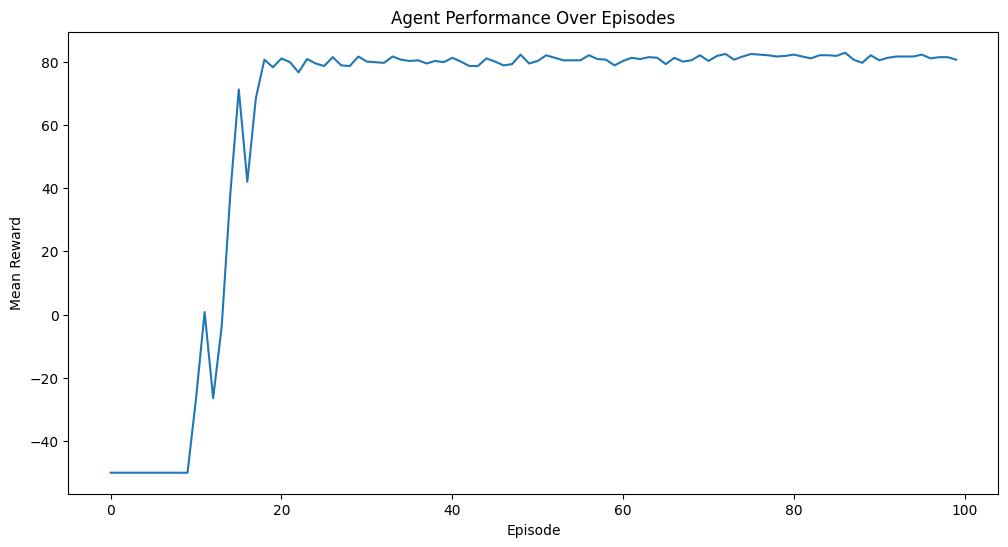

In [ ]:
def run_simulation(environment, agents, episodes, steps_per_episode):
    data = []
    for episode in range(episodes):
        episode_rewards = []
        for agent in agents:
            state = environment.reset()
            total_reward = 0
            for _ in range(steps_per_episode):
                action = agent.choose_action(state)
                next_state, reward, done = environment.step(action)
                agent.memory.add((state, action, reward, next_state), reward - agent.q_table[state][action])
                agent.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                if done:
                    break
                agent.replay()
            episode_rewards.append(total_reward)
            agent.update_epsilon()  # Gradually reduce exploration rate

        # Calculate and store statistics for the episode
        mean_reward = np.mean(episode_rewards)
        data.append({
            'episode': episode,
            'mean_reward': mean_reward,
            'min_reward': min(episode_rewards),
            'max_reward': max(episode_rewards)
        })
        print(f"Episode {episode}: Mean Reward = {mean_reward}")

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv('simulation_results.csv', index=False)
    return df

# Now call run_simulation and plot results
env = Environment(size=(10, 10), num_objects=20)
agents = [Agent(learning_rate=0.5, discount_factor=0.9, initial_epsilon=0.2, min_epsilon=0.01, epsilon_decay=0.99, buffer_size=1000) for _ in range(5)]

results_df = run_simulation(env, agents, 100, 50)
print(results_df.head())

def plot_results():
    df = pd.read_csv('simulation_results.csv')
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='episode', y='mean_reward')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Mean Reward')
    plt.show()

plot_results()
